In [1]:
# Import the packages
import pandas as pd
from google.cloud import bigquery
from google.cloud import bigquery_storage
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

g:\My Drive\APAC\Autopricing\Switchback Testing\switchback_test_dag\venv_sb\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


In [16]:
# Declare some global inputs
test_names = ["'CL_20230428_R_B0_O_AntofagastaClusteringStrategy'"]
test_start_date = "2023-04-28"
num_bootstrap_samples = 1000 # Number of data points to have on the histogram
cl = 0.95
left_threshold = round((1 - cl) / 2, 4)
right_threshold = round((1 - (1 - cl) / 2), 4)

In [17]:
# Instantiate the BQ client
client = bigquery.Client(project="dh-logistics-product-ops")
bqstorage_client = bigquery_storage.BigQueryReadClient()

g:\My Drive\APAC\Autopricing\Switchback Testing\switchback_test_dag\venv_sb\lib\site-packages\google\auth\_default.py:81: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [19]:
# Extract order data of these tests
orders_query = """
    SELECT 
        -- Identifiers and supplementary fields     
        -- Date and time
        a.created_date AS created_date_utc,

        -- Location of order
        a.region,
        a.entity_id,
        a.country_code,
        a.city_name,
        a.city_id,
        a.zone_name,
        a.zone_id,

        -- Order/customer identifiers and session data
        a.variant,
        a.experiment_id AS test_id,
        b.test_name,
        a.platform_order_code,
        a.scheme_id,
        a.vendor_price_scheme_type,	-- The assignment type of the scheme to the vendor during the time of the order, such as "Automatic", "Manual", "Campaign", and "Country Fallback".
        
        -- Vendor data and information on the delivery
        a.vendor_id,
        b.target_group AS target_group_bi,
        a.is_in_treatment,
        a.chain_id,
        a.chain_name,
        a.vertical_type,
        a.delivery_status,
        a.is_own_delivery,
        a.exchange_rate,

        -- Business KPIs (These are the components of profit)
        a.dps_delivery_fee_local,
        a.dps_travel_time_fee_local,
        a.dps_surge_fee_local,
        a.delivery_fee_local,
        IF(a.is_delivery_fee_covered_by_discount = TRUE OR a.is_delivery_fee_covered_by_voucher = TRUE, 0, a.delivery_fee_local) AS delivery_fee_local_incl_disc_and_vouchers,
        CASE WHEN ent.region != "MENA" THEN a.commission_local ELSE COALESCE(mn.commission_amount_lc, a.commission_local) END AS commission_local,
        a.joker_vendor_fee_local,
        COALESCE(a.service_fee_local, 0) AS service_fee_local,
        a.mov_customer_fee_local AS sof_local,
        a.delivery_costs_local,
        CASE
            WHEN ent.region IN ("Europe", "Asia") THEN COALESCE( -- Get the delivery fee data of Pandora countries from Pandata tables
                pd.delivery_fee_local, 
                -- In 99 pct of cases, we won"t need to use that fallback logic as pd.delivery_fee_local is reliable
                IF(a.is_delivery_fee_covered_by_discount = TRUE OR a.is_delivery_fee_covered_by_voucher = TRUE, 0, a.delivery_fee_local)
            )
            -- If the order comes from a non-Pandora country, use delivery_fee_local
            WHEN ent.region NOT IN ("Europe", "Asia") THEN (CASE WHEN a.is_delivery_fee_covered_by_discount = TRUE OR a.is_delivery_fee_covered_by_voucher = TRUE THEN 0 ELSE a.delivery_fee_local END)
        END AS actual_df_paid_by_customer,
        a.gfv_local,
        a.gmv_local
    FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders_v2` a
    LEFT JOIN `fulfillment-dwh-production.cl.dps_ab_test_orders_v2` b ON a.entity_id = b.entity_id AND a.order_id = b.order_id
    LEFT JOIN `fulfillment-dwh-production.pandata_curated.pd_orders` pd -- Contains info on the orders in Pandora countries
    ON TRUE 
        AND a.entity_id = pd.global_entity_id
        AND a.platform_order_code = pd.code 
        AND a.created_date = pd.created_date_utc -- There is no country_code field in this table
    LEFT JOIN `tlb-data-prod.data_platform.fct_billing` mn ON a.platform_order_code = CAST(mn.order_id AS STRING) AND a.entity_id IN ("TB_OM", "TB_IQ", "TB_AE", "TB_KW", "YS_TR", "TB_QA", "TB_JO", "HF_EG", "HS_SA", "TB_BH")
    INNER JOIN `dh-logistics-product-ops.pricing.entities_lb_rollout_tests` ent ON a.entity_id = ent.entity_id -- Get the region associated with every entity_id
    WHERE TRUE
        AND a.created_date >= DATE("{test_start_date}")
        AND b.test_name IN ({test_names}) -- Search for relevant tests
        AND a.is_sent -- Successful orders
        AND a.is_own_delivery -- OD orders only
        AND a.variant != "Original" -- Exclude orders from ASAs
        AND a.is_match_experiment_vertical -- Filter for sessions where the parent vertical of the vendor matches the parent vertical of the experiment	
    ;
""".format(test_names=', '.join(test_names), test_start_date=test_start_date)

# Execute the orders query
df_test_data = client.query(orders_query).result().to_dataframe(bqstorage_client=bqstorage_client, progress_bar_type="tqdm")

Downloading: 100%|██████████| 45154/45154 [00:02<00:00, 16980.57rows/s]


In [89]:
# Run the bootstrapping function sequentially
df_sim_results = []
sim_counter = 1
variants_in_test = np.sort(df_test_data["variant"].unique()).tolist() # Get the unique variants in the test and sorts them ascendingly 
for i in test_names:
    test_name_clean = i.replace("'", "")
    # Filter the data based on the test
    df_sub_test = df_test_data[df_test_data["test_name"] == test_name_clean]
    
    # Elasticity calculated by pct difference in no. of orders / pct difference in average DF
    for k in range(1, num_bootstrap_samples + 1):
        for j in variants_in_test:
            print(f"Iteration {sim_counter}. Sampling with the following parameters --> test_name: {i}, variant: {j}, and sample_num: {k}")
            df_var_sample = df_sub_test[df_sub_test["variant"] == j].sample(frac=1, replace=True)

            # Orders and avg DF
            num_orders = df_var_sample["platform_order_code"].nunique()
            avg_df = df_var_sample["dps_travel_time_fee_local"].mean()

            output_dict = {
                "test_name": test_name_clean,
                "variant": j,
                "sample_num": k,
                "num_orders": num_orders,
                "avg_df": avg_df,
            }

            df_sim_results.append(output_dict)
            
            # Increment the sim counter
            sim_counter += 1

df_sim_results = pd.DataFrame(df_sim_results)

# Convert the numeric columns to numeric data types
numeric_cols = [i for i in df_sim_results.columns if i not in ["test_name", "variant"]]
df_sim_results[numeric_cols] = df_sim_results[numeric_cols].apply(lambda x: pd.to_numeric(x))

Iteration 1. Sampling with the following parameters --> test_name: 'CL_20230428_R_B0_O_AntofagastaClusteringStrategy', variant: Control, and sample_num: 1
Iteration 2. Sampling with the following parameters --> test_name: 'CL_20230428_R_B0_O_AntofagastaClusteringStrategy', variant: Variation1, and sample_num: 1
Iteration 3. Sampling with the following parameters --> test_name: 'CL_20230428_R_B0_O_AntofagastaClusteringStrategy', variant: Variation2, and sample_num: 1
Iteration 4. Sampling with the following parameters --> test_name: 'CL_20230428_R_B0_O_AntofagastaClusteringStrategy', variant: Control, and sample_num: 2
Iteration 5. Sampling with the following parameters --> test_name: 'CL_20230428_R_B0_O_AntofagastaClusteringStrategy', variant: Variation1, and sample_num: 2
Iteration 6. Sampling with the following parameters --> test_name: 'CL_20230428_R_B0_O_AntofagastaClusteringStrategy', variant: Variation2, and sample_num: 2
Iteration 7. Sampling with the following parameters --> te

In [90]:
# Calculate the mean elasticity of LBs, non-LBs, and simple LBs per test
def percentile_left(x):
    return x.quantile(left_threshold)

def percentile_right(x):
    return x.quantile(right_threshold)

list_of_agg_functions = ["mean", percentile_left, percentile_right]
agg_func_selection = {
    "avg_df": list_of_agg_functions,
}
df_stats = df_sim_results.groupby(["test_name", "variant"])[["avg_df"]].agg(agg_func_selection).reset_index()
df_stats

test_name     variant      avg_df  \
                                                                       mean   
0  CL_20230428_R_B0_O_AntofagastaClusteringStrategy     Control  773.063256   
1  CL_20230428_R_B0_O_AntofagastaClusteringStrategy  Variation1  823.200067   
2  CL_20230428_R_B0_O_AntofagastaClusteringStrategy  Variation2  785.444853   

                                    
  percentile_left percentile_right  
0      763.247005       782.091275  
1      814.062742       832.864399  
2      777.014210       793.969118

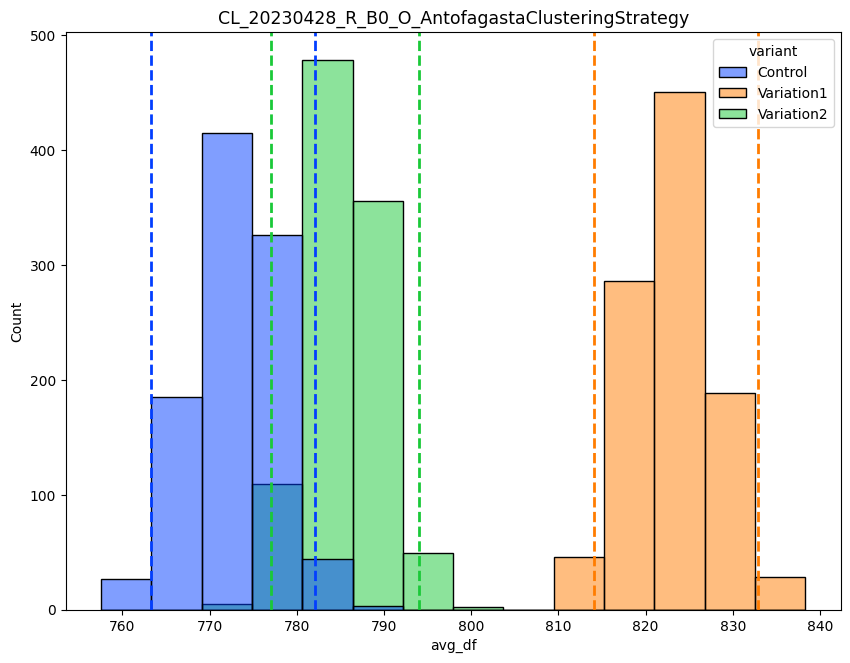

In [91]:
fig, axes = plt.subplots(figsize = (10,7.5))
def plot_func_single(test_name, kpi):
    pal = sns.color_palette("bright", len(df_sim_results['variant'].unique()))
    sns.histplot(data=df_sim_results[df_sim_results["test_name"] == test_name], x=kpi, hue="variant", palette=pal)

    for idx, var in enumerate(df_sim_results["variant"].unique()):
        # Retrieve the percentile_left and percentile_right of the variant
        percentile_left = df_stats[(df_stats["test_name"] == test_name) & (df_stats["variant"] == var)][kpi]\
        .reset_index(drop=True)["percentile_left"][0]
        percentile_right = df_stats[(df_stats["test_name"] == test_name) & (df_stats["variant"] == var)][kpi]\
        .reset_index(drop=True)["percentile_right"][0]

        # Plot the 
        axes.axvline(x = percentile_left, ymin=0, ymax=1, color=pal[idx], linestyle="--", linewidth=2)
        axes.axvline(x = percentile_right, ymin=0, ymax=1, color=pal[idx], linestyle="--", linewidth=2)

    axes.set_title(test_name, size = 12.5)

# Plot the graph
plot_func_single(test_name=test_names[0].replace("'", ""), kpi="avg_df")